# ResNet152


In [1]:
# Upgrade and install dependencies
!pip install --upgrade pip
!pip install sklearn
!pip install seaborn

     |████████████████████████████████| 2.1 MB 1.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 13.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 9.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 2.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1308 sha256=a768c206592dd609fcaad76c84c7f76c2e3c1488d716629a691c686ba1a3e731
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 3.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━

In [2]:
# Import Libraries
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix

In [3]:
# Set memory growth and list GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU name: ", tf.test.gpu_device_name())

TensorFlow version:  2.8.0
Num GPUs Available:  1
GPU name:  /device:GPU:0


# Preparation of the data sets


In [4]:
# Set image_dataset_from_directory parameters
LABELS = "inferred"
LABEL_MODE = "int"
COLOR_MODE = "rgb"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SHUFFLE = True
CROP_TO_ASPECT_RATIO = True

# For scaling and optimizing
AUTOTUNE = tf.data.AUTOTUNE

# Used for splitting val_ds
def is_test(x, y):
    return x % 2 == 0

def is_val(x, y):
    return not is_test(x, y)

def get_sets(TRAIN_DIRECTORY, VALIDATION_SPLIT, TEST_DIRECTORY):
    
    SEED = random.randint(0, 2000)

    # Create training set
    train_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TRAIN_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )
    # Create validation set
    val_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TRAIN_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split = VALIDATION_SPLIT, 
        subset = "validation",    
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )
    # Create test set
    test_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TEST_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split = None, 
        subset = None,    
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )

    # Optimizing
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

# Creating model functions

In [5]:
# Method for creating the model
def create_model():

    # Import base model and freeze layers
    base_model = tf.keras.applications.resnet.ResNet152(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape = (224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
        
    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
    # Getting output tensor of the last layer that we want to include
    x = layer_dict['conv5_block3_out'].output
    
    # Add custom layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x) 
    predictions = Dense(1, activation = None)(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
    
    # Compile model
    adamax = Adamax(learning_rate = 1e-04)
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=adamax,
    metrics=["binary_accuracy"])
    
    return model

# Plotting

In [6]:
# Method for plotting confusion matrix
def plot_cm(cf_matrix):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# Training

In [7]:
# Initialize metric arrays 
accuracy_list = []
precision_0_list = []
recall_0_list = []
precision_1_list = []
recall_1_list = []
f1_0_list=[]
f1_1_list=[]
cm = np.array([[0,0],[0,0]])

# Run loop 10 times
for lp in range(10):
    
    print("\n<*************************************************************************************************************>")
    print("\nIteration nr: " + str(lp + 1))
    print("\n<*************************************************************************************************************>\n")
    
    # Create the model
    model = create_model()

    # Get datasets
    train_ds, val_ds, test_ds = get_sets("datasets/Split_0-Binary-Augmented", 0.2, "datasets/Split_1-Binary")
    
    # Train model
    model.fit(
        train_ds, 
        epochs=100, 
        batch_size=32, 
        validation_data=val_ds,
        callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
        ]
    )
        
    # Create set for predictions
    test_batches = tf.data.experimental.cardinality(test_ds)
    test_dataset = test_ds.take(test_batches // 5)

    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(label_batch, predictions.numpy()).ravel()
    cm += confusion_matrix(label_batch, predictions.numpy())
    
    # Accuracy
    acc = (tn+tp)*100/(tp+tn+fp+fn) 
    accuracy_list.append(acc)

    # Precision class 1
    if (tp+fp) > 0:
        precision_1 = (float(tp))/float(tp+fp)
    else: 
        precision_1 = 0.0
    precision_1_list.append(precision_1)

    # Recall class 1
    recall_1 = float(tp)/(tp+fn) 
    recall_1_list.append(recall_1)

    # Precision class 0
    precision_0 = (float(tn))/(tn+fn)
    precision_0_list.append(precision_0)

    # Recall class 0 
    recall_0 = float(tn)/(tn+fp) 
    recall_0_list.append(recall_0)

    # F1 Score class 1
    if (precision_1 + recall_1) > 0:
        f1_1 = (2*precision_1*recall_1)/(precision_1 + recall_1)
    else:
        f1_1=0.0
    f1_1_list.append(f1_1)
    
    # F1 Score class 0
    f1_0 = (2*precision_0*recall_0)/(precision_0 + recall_0)
    f1_0_list.append(f1_0)


<*************************************************************************************************************>

Iteration nr: 1

<*************************************************************************************************************>

234708992/234698864 [==============================] - 18s 0us/step
Found 42764 files belonging to 2 classes.
Using 34212 files for training.
Found 42764 files belonging to 2 classes.
Using 8552 files for validation.
Found 24092 files belonging to 2 classes.
Epoch 1/100
1070/1070 [==============================] - 268s 241ms/step - loss: 0.4067 - binary_accuracy: 0.8408 - val_loss: 0.2731 - val_binary_accuracy: 0.8646
Epoch 2/100
1070/1070 [==============================] - 256s 239ms/step - loss: 0.1669 - binary_accuracy: 0.9310 - val_loss: 0.2102 - val_binary_accuracy: 0.9013
Epoch 3/100
1070/1070 [==============================] - 253s 236ms/step - loss: 0.0982 - binary_accuracy: 0.9613 - val_loss: 0.1616 - val_binary_accuracy: 0.9336
Epoch 4/

Found 42764 files belonging to 2 classes.
Using 8552 files for validation.
Found 24092 files belonging to 2 classes.
Epoch 1/100
1070/1070 [==============================] - 266s 242ms/step - loss: 0.4204 - binary_accuracy: 0.8305 - val_loss: 0.2444 - val_binary_accuracy: 0.9031
Epoch 2/100
1070/1070 [==============================] - 253s 236ms/step - loss: 0.1786 - binary_accuracy: 0.9263 - val_loss: 0.1974 - val_binary_accuracy: 0.9277
Epoch 3/100
1070/1070 [==============================] - 250s 234ms/step - loss: 0.1042 - binary_accuracy: 0.9595 - val_loss: 0.1675 - val_binary_accuracy: 0.9350
Epoch 4/100
1070/1070 [==============================] - 250s 233ms/step - loss: 0.0618 - binary_accuracy: 0.9781 - val_loss: 0.1571 - val_binary_accuracy: 0.9402
Epoch 5/100
1070/1070 [==============================] - 248s 231ms/step - loss: 0.0442 - binary_accuracy: 0.9852 - val_loss: 0.1807 - val_binary_accuracy: 0.9412
Epoch 6/100
1070/1070 [==============================] - 248s 231ms/

Epoch 4/100
1070/1070 [==============================] - 248s 232ms/step - loss: 0.0716 - binary_accuracy: 0.9742 - val_loss: 0.1637 - val_binary_accuracy: 0.9371
Epoch 5/100
1070/1070 [==============================] - 248s 232ms/step - loss: 0.0469 - binary_accuracy: 0.9852 - val_loss: 0.1640 - val_binary_accuracy: 0.9371
Epoch 6/100
1070/1070 [==============================] - 260s 243ms/step - loss: 0.0287 - binary_accuracy: 0.9923 - val_loss: 0.1802 - val_binary_accuracy: 0.9323
Epoch 7/100
1070/1070 [==============================] - 259s 242ms/step - loss: 0.0203 - binary_accuracy: 0.9947 - val_loss: 0.1614 - val_binary_accuracy: 0.9438
Epoch 8/100
1070/1070 [==============================] - 251s 234ms/step - loss: 0.0144 - binary_accuracy: 0.9968 - val_loss: 0.1624 - val_binary_accuracy: 0.9448
Epoch 9/100
1070/1070 [==============================] - 255s 238ms/step - loss: 0.0114 - binary_accuracy: 0.9974 - val_loss: 0.1688 - val_binary_accuracy: 0.9452
Epoch 10/100
1070/1070

# Results

In [8]:
# Average values
print ("Accuracy average:", sum(accuracy_list)/len(accuracy_list))
print ("Accuracy list:", accuracy_list)
print ("\nPrecision_1:", sum(precision_1_list)/len(precision_1_list))
print ("Presicion_0:", sum(precision_0_list)/len(precision_0_list))
print ("\nRecall_1:", sum(recall_1_list)/len(recall_1_list))
print ("Recall_0:", sum(recall_0_list)/len(recall_0_list))
print ("\nF1_1:", sum(f1_1_list)/len(f1_1_list))
print ("F1_0:", sum(f1_0_list)/len(f1_0_list))

Accuracy average: 64.0625
Accuracy list: [56.25, 62.5, 53.125, 78.125, 78.125, 75.0, 59.375, 59.375, 71.875, 46.875]

Precision_1: 0.4204988414129954
Presicion_0: 0.9637499999999999

Recall_1: 0.9391233766233766
Recall_0: 0.5370431035290371

F1_1: 0.569476776231767
F1_0: 0.6824014900485489


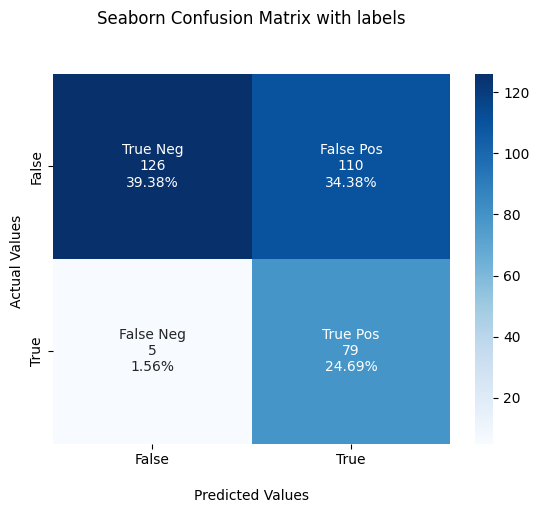

In [9]:
# Plot confusion matrix from average
plot_cm(cm)